<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/bias_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [13]:
import gensim.downloader as api
from gensim.matutils import cossim
from gensim.models import KeyedVectors
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import paired_euclidean_distances
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Load Files

**Annotations** contains crowdsourced annotations for response sentiment and relevance on source-response pairs obtained as described in the paper *RtGender: A Corpus for Studying Differential Responses to Gender* by Rob Voigt, David Jurgens, Vinodkumar Prabhakaran, Dan Jurafsky and Yulia Tsvetkov. Documentation is available [here](https://nlp.stanford.edu/robvoigt/rtgender/).

In [3]:
file_path_annotations = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/annotations.csv'
file_path_googlenews = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/word2vec-google-news-300.model'
file_path_document_bias = '/content/drive/MyDrive/SIADS 696: Milestone II/Project/Data/RtGender/document-bias.csv'

In [4]:
dataframe_annotations = pd.read_csv(file_path_annotations)
dataframe_annotations.head()

,source,op_gender,post_text,response_text,sentiment,relevance
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant


**Google News** contains a pre-trained Word2Vec model based on the Google News dataset, covering approximately 3 million words and phrases. Documentation is available [here](https://code.google.com/archive/p/word2vec/) and [here](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py).

In [5]:
# model_googlenews = api.load('word2vec-google-news-300')
# model_googlenews.save(file_path_googlenews)

In [6]:
model_googlenews = KeyedVectors.load(file_path_googlenews, mmap='r')

In [7]:
for index, word in enumerate(model_googlenews.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_googlenews.index_to_key)} is {word}")

word #0/3000000 is </s>
word #1/3000000 is in
word #2/3000000 is for
word #3/3000000 is that
word #4/3000000 is is
word #5/3000000 is on
word #6/3000000 is ##
word #7/3000000 is The
word #8/3000000 is with
word #9/3000000 is said


In [8]:
model_googlenews.most_similar('she')

[('her', 0.7834683060646057),
 ('She', 0.7553189396858215),
 ('herself', 0.669890820980072),
 ('hers', 0.6509943008422852),
 ('he', 0.612994909286499),
 ('woman', 0.5641393661499023),
 ('Rivadineira', 0.558593213558197),
 ('Jana_Bobek', 0.5365386605262756),
 ('mother', 0.5349627137184143),
 ("she'sa", 0.5337814688682556)]

In [9]:
model_googlenews.most_similar('he')

[('He', 0.6712614297866821),
 ('him', 0.6681135892868042),
 ('his', 0.6201768517494202),
 ('she', 0.612994909286499),
 ('himself', 0.588027834892273),
 ('nobody', 0.5637064576148987),
 ('I', 0.555713951587677),
 ('it', 0.5354882478713989),
 ('never', 0.5239652395248413),
 ('somebody', 0.5205153822898865)]

Nouns from v1.1 of the **HolisticBias** dataset, a project of the Responsible Natural Language Processing team at Facebook Research. The dataset is described in the paper **"I'm sorry to hear that": Finding New Biases in Language Models with a Holistic Descriptor Dataset** by Eric Michael Smith, Melissa Hall, Melanie Kambadur, Eleonora Presani, and Adina Williams. Documentation is available [here](https://github.com/facebookresearch/ResponsibleNLP/tree/main/holistic_bias/dataset/v1.1).

In [51]:
nouns = {
    "female": [
        ["woman", "women"],
        ["lady", "ladies"],
        ["gal", "gals"],
        ["girl", "girls"],
        ["mother", "mothers"],
        ["mom", "moms"],
        ["daughter", "daughters"],
        ["wife", "wives"],
        ["grandmother", "grandmothers"],
        ["grandma", "grandmas"],
        ["sister", "sisters"],
        # ["sista", "sistas"]
    ],
    "male": [
        ["man", "men"],
        ["bro", "bros"],
        ["guy", "guys"],
        ["boy", "boys"],
        ["father", "fathers"],
        ["dad", "dads"],
        ["son", "sons"],
        ["husband", "husbands"],
        ["grandfather", "grandfathers"],
        ["grandpa", "grandpas"],
        ["brother", "brothers"]
    ],
    "neutral": [
        ["individual", "individuals"],
        ["person", "people"],
        ["kid", "kids"],
        ["parent", "parents"],
        ["child", "children"],
        ["spouse", "spouses"],
        ["grandparent", "grandparents"],
        ["sibling", "siblings"],
        ["veteran", "veterans"]
    ]
}

In [52]:
data_holisticbias = [[gender, ' '.join([word for pair in words_list for word in pair])] for gender, words_list in nouns.items()]
dataframe_holisticbias = pd.DataFrame(data_holisticbias, columns=['gender', 'text'])
dataframe_holisticbias

,gender,text
0,female,woman women lady ladies gal gals girl girls mo...
1,male,man men bro bros guy guys boy boys father fath...
2,neutral,individual individuals person people kid kids ...


## Tokenize Text

In [12]:
stop_words = text.ENGLISH_STOP_WORDS
print(sorted(stop_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give

Several of the stop words in scikit-learn encode gender, including he, him, his, and himself (male); she, her, hers, herself (female); and potentially they, them, their, and themselves (nonbinary). It might be preferable to retain stop words and set a maximum document frequency.

In [14]:
tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True, match_phone_numbers=False)

In [31]:
def tokenize_text(dataframe, text_column, tokens_column, tokenizer):
    """
    Tokenizes text data in a pandas DataFrame using a specified tokenizer and adds the tokens to a new column.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the text data.
    - text_column (str): The name of the column containing the text to be tokenized.
    - tokens_column (str): The name of the new column where tokenized text will be stored.
    - tokenizer: An instance of a tokenizer class that has a `tokenize` method.

    Returns:
    - pd.DataFrame: A DataFrame with an additional column for tokenized text.

    Note:
    This function modifies the input DataFrame by adding a new column for the tokenized text.
    It first removes rows with missing values in the `text_column` to ensure proper tokenization.
    """
    # Ensure that we are working with a copy of the DataFrame to avoid SettingWithCopyWarning
    dataframe = dataframe.dropna(subset=[text_column]).copy()

    # Tokenize the text in each row and assign the result to the tokens_column
    dataframe[tokens_column] = dataframe[text_column].map(lambda x: tokenizer.tokenize(x))

    return dataframe

In [36]:
dataframe_annotations_tokenized = tokenize_text(dataframe_annotations, 'response_text', 'response_tokens', tokenizer)
dataframe_annotations_tokenized.head()

,source,op_gender,post_text,response_text,sentiment,relevance,response_tokens
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster,"[you, are, both, sweet, ashley, tisdale, and, ..."
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content,"[give, us, the, first, page, to, read, ., one,..."
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content,"[this, is, my, city, was, there, 2, weeks, a, go]"
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content,"[if, grizzly, adams, had, a, beard, .]"
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant,"[good, morning, lourdes, ,, have, a, great, da..."


## Apply Word Embeddings

In [48]:
def get_embeddings(dataframe, tokens_column, embedding_column, model):
    """
    Computes embeddings for tokens in a dataframe using a specified model.

    This function creates a copy of the input dataframe to avoid the SettingWithCopyWarning.
    It then applies a map function to calculate embeddings for each row in the specified tokens column,
    using a pre-defined get_mean_vector method on the model. The result is stored in a new column.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing tokens.
    - tokens_column (str): The column name in `dataframe` containing the tokens.
    - embedding_column (str): The column name where embeddings should be stored.
    - model: The model used for generating embeddings. This model should have a `get_mean_vector` method.

    Returns:
    - pd.DataFrame: A copy of `dataframe` with an additional column for embeddings.
    """
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    dataframe = dataframe.copy()

    # Calculate and store embeddings
    dataframe[embedding_column] = dataframe[tokens_column].map(lambda x: model.get_mean_vector(x))

    return dataframe

In [49]:
dataframe_annotations_vectorized = get_embeddings(dataframe_annotations_tokenized, 'response_tokens', 'response_vector', model_googlenews)
dataframe_annotations_vectorized.head()

,source,op_gender,post_text,response_text,sentiment,relevance,response_tokens,response_vector
0,facebook_wiki,W,Stopped by Fashion Week and got to hang with A...,You are Both Sweet Ashley Tisdale and Lauren C...,Positive,Poster,"[you, are, both, sweet, ashley, tisdale, and, ...","[-0.0013465781, -0.0057732607, -0.0013192147, ..."
1,facebook_wiki,M,"Well guys, real progress is happening. I'm 50 ...",Give us the first page to read. ONE PAGE.,Mixed,Content,"[give, us, the, first, page, to, read, ., one,...","[0.041221574, -0.013094896, 0.017267864, 0.033..."
2,facebook_wiki,W,Tonight is going to be a good night #PerfectMo...,this is my city was there 2 weeks a go,Neutral,Content,"[this, is, my, city, was, there, 2, weeks, a, go]","[0.017657118, 0.018749667, 0.025034808, 0.0353..."
3,facebook_wiki,M,I know grandma Gilmore is real proud of you ht...,if grizzly Adams had a beard.,Neutral,Content,"[if, grizzly, adams, had, a, beard, .]","[-0.00089835376, 0.0147805335, -0.004006531, 0..."
4,facebook_wiki,W,#NEWS to KNOW this AM - Mayor Emanuel will mak...,"Good morning Lourdes, have a great day! Great ...",Positive,Irrelevant,"[good, morning, lourdes, ,, have, a, great, da...","[-0.019836605, 0.04604669, -0.016793199, 0.039..."


Garg et al. (2018) use a different approach to assess the similarity between a set of neutral words and two groups, first subtracting the distance between each group and a neutral word, then summing the results across words. This approach gives equal weight to each word, unlike the approach above.

## Calculate Bias

In [67]:
male_nouns = [item for sublist in nouns['male'] for item in sublist]
female_nouns = [item for sublist in nouns['female'] for item in sublist]

In [68]:
def calculate_bias(dataframe, embedding_column, bias_column, male_tokens, female_tokens, model):
    """
    Calculates and adds a bias score for each row in a DataFrame based on the Euclidean distance of embeddings
    to predefined male and female token vectors.

    This function computes a bias score for each embedding by calculating the difference between the Euclidean
    distance of the embedding to a mean male token vector and its distance to a mean female token vector.
    A positive score indicates closer proximity to male tokens, whereas a negative score suggests closer proximity
    to female tokens.

    Parameters:
    - dataframe (pd.DataFrame): DataFrame containing the embeddings.
    - embedding_column (str): Column name in `dataframe` containing the embeddings.
    - bias_column (str): Column name where the calculated bias scores will be stored.
    - male_tokens (list of str): Tokens considered to represent male attributes.
    - female_tokens (list of str): Tokens considered to represent female attributes.
    - model: Pre-trained word embedding model used to compute mean vectors for male and female tokens.

    Returns:
    - pd.DataFrame: A copy of `dataframe` with an additional `bias_column` containing the bias scores.
    """
    # Compute mean vectors for male and female tokens
    male_vector = model.get_mean_vector(male_tokens)
    female_vector = model.get_mean_vector(female_tokens)

    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    dataframe = dataframe.copy()

    # Calculate bias scores and store in bias_column
    dataframe[bias_column] = dataframe[embedding_column].map(
        lambda x: np.linalg.norm(male_vector - x) - np.linalg.norm(female_vector - x)
    )

    return dataframe

In [75]:
dataframe_bias = calculate_bias(dataframe_annotations_vectorized, 'response_vector', 'bias_calculation', male_nouns, female_nouns, model_googlenews)
dataframe_bias.sort_values('bias_calculation')

,source,op_gender,post_text,response_text,sentiment,relevance,response_tokens,response_vector,bias_calculation
1291,facebook_wiki,W,I love this story....so nice!,God Bless You Brother!,Positive,Irrelevant,"[god, bless, you, brother, !]","[0.05326841, 0.01748268, 0.027004052, 0.053192...",-0.131889
1462,facebook_wiki,M,Some of my kidney stuff is on YouTube http://m...,God bless ya brother.,Positive,Content,"[god, bless, ya, brother, .]","[0.038112327, 0.023205511, 0.03145609, 0.04191...",-0.128856
8153,fitocracy,W,just joined the Fitocracy Team Fitness group!,"Yeeeah, buddy! Awesome stuff!",Positive,Content,"[yeeeah, ,, buddy, !, awesome, stuff, !]","[0.027899146, -0.0026028852, -0.018221922, 0.0...",-0.119475
7866,fitocracy,M,"Thanks for the follow, FB. Good luck with your...","Thanks, Brother. You too.",Positive,Poster,"[thanks, ,, brother, ., you, too, .]","[0.021554783, 0.020424597, 0.010973428, 0.0584...",-0.115938
12471,reddit,W,"Reading the top comments in this thread, I jus...",He yelled allahu ackbar,Mixed,Content,"[he, yelled, allahu, ackbar]","[0.081659466, 0.018219694, 0.043187827, -0.007...",-0.112012
...,...,...,...,...,...,...,...,...,...
14149,ted,W,"Julia Sweeney gave a talk about Christianity, ...","Julia is so adorable. Her intelligence, her st...",Positive,Content,"[julia, is, so, adorable, ., her, intelligence...","[0.022349916, -0.0011621907, -0.006151491, 0.0...",0.078805
1156,facebook_wiki,W,Good luck to our Dan Ponce Sarah Jindra and Co...,Two beautiful women!!,Positive,ContentPoster,"[two, beautiful, women, !, !]","[-0.0148772225, 0.009522311, 0.0010693908, 0.0...",0.082767
146,facebook_wiki,W,Saw THE BUTLER. My ANTM cycle 3 alum Yaya does...,Shes a great actress!!!,Positive,Content,"[shes, a, great, actress, !, !, !]","[-0.0023426886, -0.0026900147, -0.03922738, 0....",0.086396
12784,ted,W,"Julie Taymor gave a talk about creativity, ent...",Beautiful woman and beautiful story!,Positive,Content,"[beautiful, woman, and, beautiful, story, !]","[0.03604141, 0.005609255, -0.027860396, 0.0069...",0.086867


The advantage of using cosine similarity is that the distance between vectors is normalized. However, because the number of male and female nouns in the HolisticBias dataset is similar, it may not be necessary to use a normalized measure, particularly if computational efficiency is compromised. Garg et al. (2018) use Euclidean distance.

(array([1.17000712e-02, 1.75500951e-02, 3.51002137e-02, 8.19004438e-02,
        1.46250890e-01, 8.01454879e-01, 3.28771781e+00, 1.38528843e+01,
        3.27952887e+01, 2.51317446e+01, 8.14324753e+00, 3.18826861e+00,
        1.18755683e+00, 6.66903948e-01, 2.51551447e-01, 9.36005385e-02,
        5.26503029e-02, 2.34001424e-02, 5.85003170e-03, 2.34001424e-02]),
 array([-0.13188881, -0.12075271, -0.1096166 , -0.0984805 , -0.08734439,
        -0.07620829, -0.06507219, -0.05393609, -0.04279999, -0.03166388,
        -0.02052778, -0.00939168,  0.00174443,  0.01288053,  0.02401663,
         0.03515273,  0.04628884,  0.05742494,  0.06856104,  0.07969715,
         0.09083325]),
 <BarContainer object of 20 artists>)

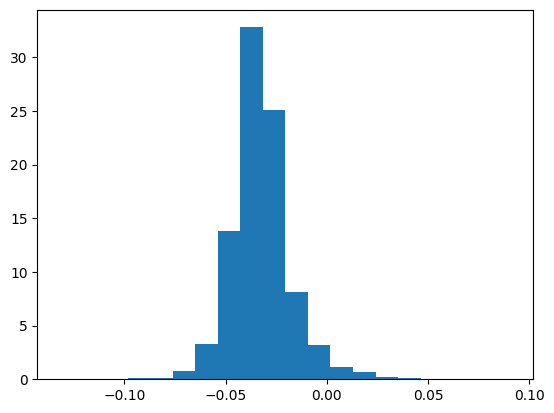

In [76]:
plt.hist(dataframe_bias['bias_calculation'], bins=20, density=True)

(array([1.18811917e-02, 2.37623674e-02, 3.56435750e-02, 1.06930653e-01,
        8.31683417e-02, 5.10891242e-01, 2.50692977e+00, 1.16435678e+01,
        3.17346523e+01, 2.56990090e+01, 9.81386186e+00, 4.13465366e+00,
        1.78217815e+00, 9.50495175e-01, 4.39603945e-01, 1.54455440e-01,
        7.12871262e-02, 3.56435750e-02, 1.18811837e-02, 4.75247667e-02]),
 array([-0.13188881, -0.12075271, -0.1096166 , -0.0984805 , -0.08734439,
        -0.07620829, -0.06507219, -0.05393609, -0.04279999, -0.03166388,
        -0.02052778, -0.00939168,  0.00174443,  0.01288053,  0.02401663,
         0.03515273,  0.04628884,  0.05742494,  0.06856104,  0.07969715,
         0.09083325]),
 <BarContainer object of 20 artists>)

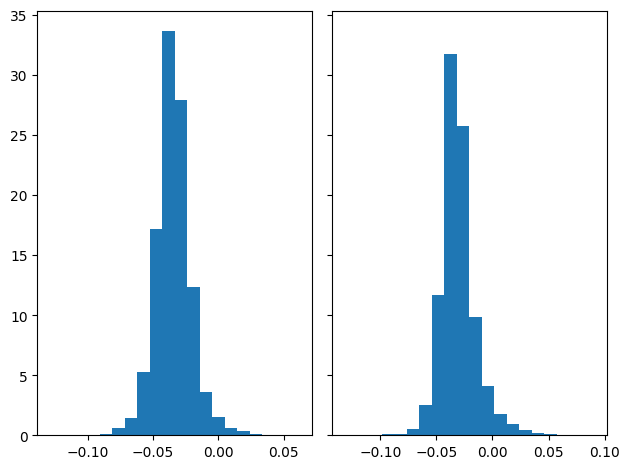

In [77]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(dataframe_bias[dataframe_bias['op_gender'] == 'M']['bias_calculation'], bins=20, density=True)
axs[1].hist(dataframe_bias[dataframe_bias['op_gender'] == 'W']['bias_calculation'], bins=20, density=True)

## References

"Please annotate the following code and convert it into PEP 8." OpenAI. (2023). ChatGPT (Jan 30 version) [Large language model]. https://chat.openai.com/chat

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. PNAS, 115(16). https://doi.org/10.1073/pnas.1720347115

## Deprecated

It is not necessary to vectorize the data, only to tokenize the data. In fact, using a vectorizer leads to unnecessary processing downstream.

In [10]:
# def initialize_vectorizer(vectorizer):
#     """
#     Initializes and configures an instance of a vectorizer class.

#     This function takes a vectorizer class (such as CountVectorizer or TfidfVectorizer
#     from sklearn.feature_extraction.text) and initializes it with specific configuration
#     parameters.

#     Args:
#         vectorizer (class): The class of the vectorizer to be initialized.

#     Returns:
#         object: An instance of the specified vectorizer class with configured parameters.
#     """

#     # Initialize the vectorizer with specific configuration settings
#     instance = vectorizer(
#         strip_accents='unicode',
#         lowercase=False,
#         stop_words=None,
#         ngram_range=(1, 1),
#         min_df=1,
#         max_df=1,
#         max_features=None
#     )

#     return instance

In [11]:
# def tokenize_text(dataframe, label_column, text_column, vectorizer):
#     """
#     Tokenizes text data in a pandas DataFrame using a specified vectorizer.

#     Args:
#     - dataframe (pd.DataFrame): The DataFrame containing the text data.
#     - label_column (str): The name of the column containing the labels.
#     - text_column (str): The name of the column containing the text to be tokenized.
#     - vectorizer (Vectorizer): An instance of a text vectorization class from sklearn.

#     Returns:
#     - matrix (sparse matrix): The transformed text data as a matrix.
#     - labels (pd.Series): The labels associated with the text data.
#     - features (np.ndarray): The features associated with the text data.
#     """
#     # Remove rows with missing values in the text column
#     dataframe = dataframe.dropna(subset=[text_column])

#     # Transform the text column into a matrix
#     matrix = vectorizer.fit_transform(dataframe[text_column])

#     # Extract the target variable
#     labels = dataframe[label_column]

#     # Extract feature names
#     features = vectorizer.get_feature_names_out()

#     return matrix, labels, features

In [12]:
# Initialize vectorizers
# count_vectorizer = initialize_vectorizer(CountVectorizer)
# tfidf_vectorizer = initialize_vectorizer(TfidfVectorizer)

In [13]:
# Tokenize posts
# matrix_count, labels_count, features_count = tokenize_text(dataframe_annotations, 'op_gender', 'response_text', count_vectorizer)
# matrix_tfidf, labels_tfidf, features_tfidf = tokenize_text(dataframe_annotations, 'op_gender', 'response_text', tfidf_vectorizer)

In [ ]:
# Tokenize nouns
# gender_matrix_count = count_vectorizer.transform(dataframe_holisticbias['text'])
# gender_matrix_tfidf = tfidf_vectorizer.transform(dataframe_holisticbias['text'])

In [ ]:
# def get_embeddings(model, vectorizer):
#     """
#     Pre-computes word embeddings for the entire vocabulary.

#     Args:
#     - model (Word2Vec KeyedVectors): Pre-trained Word2Vec model.
#     - vocabulary (list of str): The list of words in the vocabulary.

#     Returns:
#     - dict: A dictionary mapping words to their respective embeddings.
#     """
#     vocabulary = vectorizer.vocabulary_.keys()
#     return {word: model[word] for word in vocabulary if word in model}

In [ ]:
# embeddings_count = get_embeddings(model_googlenews, count_vectorizer)
# embeddings_tfidf = get_embeddings(model_googlenews, tfidf_vectorizer)

In [ ]:
# def get_word2vec_vector(matrix, features, embeddings, dimensions=300):
#     # ENUMERATE OVER WORDS IN DOCUMENT INSTEAD OF FEATURES IN COUNTVECTORIZER OR TFIDFVECTORIZER
#     """
#     Generate normalized Word2Vec vectors for documents in a given matrix.

#     Args:
#     matrix (sparse matrix): A matrix where each row represents a document and each column represents a feature.
#     features (np.ndarray): An array of words corresponding to the columns in the matrix.
#     model (Word2Vec KeyedVectors): Pre-trained Word2Vec model.
#     dimensions (int): Dimensionality of the Word2Vec vectors.

#     Yields:
#     np.ndarray: Normalized Word2Vec vector for each document.
#     """
#     # Get the number of documents in the matrix
#     num_documents = matrix.shape[0]

#     # Iterate over each document in the matrix
#     for i in range(num_documents):
#         # Initialize the vector for the current document
#         document_vector = np.zeros(dimensions)
#         # Initialize the total weight for the current document
#         document_weight = 0

#         # Iterate over each word in the features list
#         for j, word in enumerate(features):
#             # Check if the word is in the model
#             if word in embeddings:
#                 # Get the weight of the word in the current document
#                 word_weight = matrix[i, j]
#                 # Get the vector representation of the word and scale it by its weight
#                 word_vector = embeddings[word] * word_weight
#                 # Add the weighted word vector to the document vector
#                 document_vector += word_vector
#                 # Accumulate the total weight of the words in the document
#                 document_weight += word_weight

#         # Avoid division by zero
#         document_weight = document_weight if document_weight > 0 else 1

#         # Yield the normalized document vector
#         yield document_vector / document_weight

In [ ]:
# def calculate_bias(male_vector, female_vector, document_vector, distance_function=paired_euclidean_distances):
#     """
#     Calculate the bias in document vectors towards male or female vectors.

#     This function computes the distance between a document vector and
#     both female and male vectors using either euclidean distance or cosine similarity.
#     It returns the difference in distances, which can be interpreted as a bias measure
#     towards one of the genders.

#     Parameters:
#     - male_vector (numpy.ndarray): A vector representing male attributes.
#     - female_vector (numpy.ndarray): A vector representing female attributes.
#     - document_vector (numpy.ndarray): A vector representing a document.
#     - measure (str): The type of distance measure to use ('euclidean' or 'cosine').

#     Returns:
#     - float: The difference in distances between the document vector
#              and the female and male vectors, indicating gender bias.
#     """

#     # Reshape vectors to 2D arrays to fit the input requirement of distance functions
#     female_vector = female_vector.reshape(1, -1)
#     male_vector = male_vector.reshape(1, -1)
#     document_vector = document_vector.reshape(1, -1)

#     # Calculate distance between document and gender vectors
#     female_document_distance = distance_function(female_vector, document_vector)
#     male_document_distance = distance_function(male_vector, document_vector)

#     # Return the difference in distances as a measure of bias
#     return float(female_document_distance - male_document_distance)

In [70]:
# Get word2vec vectors for male and female nouns
# gender_word2vec = get_word2vec_vector(gender_matrix_count, features_count, embeddings_count)
# female_vector = next(gender_word2vec)
# male_vector = next(gender_word2vec)
# neutral_vector = next(gender_word2vec)

# Get word2vec vectors for first five documents
# document_word2vec = get_word2vec_vector(matrix_count, features_count, embeddings_count)
# document_a = next(document_word2vec)
# document_b = next(document_word2vec)
# document_c = next(document_word2vec)
# document_d = next(document_word2vec)
# document_e = next(document_word2vec)

# Calculate bias in first five documents
# print(calculate_bias(female_vector, male_vector, document_a))
# print(calculate_bias(female_vector, male_vector, document_b))
# print(calculate_bias(female_vector, male_vector, document_c))
# print(calculate_bias(female_vector, male_vector, document_d))
# print(calculate_bias(female_vector, male_vector, document_e))

In [71]:
# document_word2vec = get_word2vec_vector(matrix_tfidf, features_tfidf, embeddings_tfidf)
# document_bias = np.zeros(int(matrix_tfidf.shape[0]))
# for i, document in tqdm(enumerate(document_word2vec)):
#   document_bias[i] = calculate_bias(female_vector, male_vector, document)